In [1]:
import numpy as np
import matplotlib.pyplot as plt
import 

In [2]:
def unpickle(file):
    import pickle
    with open(file, 'rb') as fo:
        dict = pickle.load(fo, encoding='bytes')
    return dict

train_set = unpickle('train')

In [64]:
train_set.keys()

dict_keys([b'filenames', b'batch_label', b'fine_labels', b'coarse_labels', b'data'])

In [17]:
train_set[b'data'].shape

(50000, 3072)

In [3]:
red = train_set[b'data'][:,0:1024]
green = train_set[b'data'][:,1024:2048]
blue = train_set[b'data'][:,2048:3072]

In [111]:
red.shape

(50000, 1024)

In [112]:
blue.shape

(50000, 1024)

In [15]:
green.shape

(50000, 1024)

In [29]:
red[0].shape
red[0][18]

231

In [ ]:
Y = (( 66 * R + 129 * G +  25 * B + 128) / 256) +  16;
U = ((-38 * R -  74 * G + 112 * B + 128) / 256) + 128;
V = ((112 * R -  94 * G -  18 * B + 128) / 256) + 128;

In [73]:
train_set[b'filenames'][200]

b'keyboard_s_000991.png'

In [12]:
img0 = np.empty((red[0].shape[0],3))
for i in range(len(red[0])):
    Y = (( 66 * red[0][i] + 129 * green[0][i] +  25 * blue[0][i] + 128) / 256) +  16
    U = ((-38 * red[0][i] -  74 * green[0][i] + 112 * blue[0][i] + 128) / 256) + 128
    V = ((112 * red[0][i] -  94 * green[0][i] -  18 * blue[0][i] + 128) / 256) + 128
    img0[i] = [Y,U,V]

print(img0)
img0_array = np.reshape(np.array(img0,dtype=int),(32,32,3))


[[235.640625  128.5       128.5      ]
 [235.640625  128.5       128.5      ]
 [235.640625  128.5       128.5      ]
 ...
 [ 44.3828125 117.421875  129.453125 ]
 [116.3515625 100.28125   121.453125 ]
 [146.96875    92.5703125 119.796875 ]]


In [16]:
img0_array[:,:,0]

array([[235, 235, 235, ..., 188, 203, 177],
       [235, 234, 234, ..., 163, 155, 142],
       [235, 234, 235, ..., 182, 161, 123],
       ...,
       [155, 150, 148, ...,  32,  65,  76],
       [133, 131, 136, ...,  30, 103, 142],
       [104, 104, 115, ...,  44, 116, 146]])

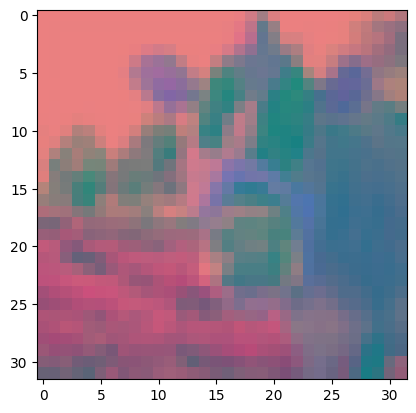

In [13]:

plt.imshow(img0_array)

In [19]:
img0_array[:,:,0]

array([[235, 235, 235, ..., 188, 203, 177],
       [235, 234, 234, ..., 163, 155, 142],
       [235, 234, 235, ..., 182, 161, 123],
       ...,
       [155, 150, 148, ...,  32,  65,  76],
       [133, 131, 136, ...,  30, 103, 142],
       [104, 104, 115, ...,  44, 116, 146]])

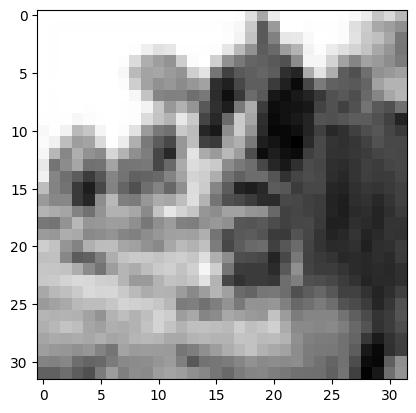

In [24]:

plt.imshow(img0_array[:,:,0],cmap="gray")


ValueError: 'uv' is not a valid value for cmap; supported values are 'Accent', 'Accent_r', 'Blues', 'Blues_r', 'BrBG', 'BrBG_r', 'BuGn', 'BuGn_r', 'BuPu', 'BuPu_r', 'CMRmap', 'CMRmap_r', 'Dark2', 'Dark2_r', 'GnBu', 'GnBu_r', 'Grays', 'Greens', 'Greens_r', 'Greys', 'Greys_r', 'OrRd', 'OrRd_r', 'Oranges', 'Oranges_r', 'PRGn', 'PRGn_r', 'Paired', 'Paired_r', 'Pastel1', 'Pastel1_r', 'Pastel2', 'Pastel2_r', 'PiYG', 'PiYG_r', 'PuBu', 'PuBuGn', 'PuBuGn_r', 'PuBu_r', 'PuOr', 'PuOr_r', 'PuRd', 'PuRd_r', 'Purples', 'Purples_r', 'RdBu', 'RdBu_r', 'RdGy', 'RdGy_r', 'RdPu', 'RdPu_r', 'RdYlBu', 'RdYlBu_r', 'RdYlGn', 'RdYlGn_r', 'Reds', 'Reds_r', 'Set1', 'Set1_r', 'Set2', 'Set2_r', 'Set3', 'Set3_r', 'Spectral', 'Spectral_r', 'Wistia', 'Wistia_r', 'YlGn', 'YlGnBu', 'YlGnBu_r', 'YlGn_r', 'YlOrBr', 'YlOrBr_r', 'YlOrRd', 'YlOrRd_r', 'afmhot', 'afmhot_r', 'autumn', 'autumn_r', 'binary', 'binary_r', 'bone', 'bone_r', 'brg', 'brg_r', 'bwr', 'bwr_r', 'cividis', 'cividis_r', 'cool', 'cool_r', 'coolwarm', 'coolwarm_r', 'copper', 'copper_r', 'cubehelix', 'cubehelix_r', 'flag', 'flag_r', 'gist_earth', 'gist_earth_r', 'gist_gray', 'gist_gray_r', 'gist_grey', 'gist_heat', 'gist_heat_r', 'gist_ncar', 'gist_ncar_r', 'gist_rainbow', 'gist_rainbow_r', 'gist_stern', 'gist_stern_r', 'gist_yarg', 'gist_yarg_r', 'gist_yerg', 'gnuplot', 'gnuplot2', 'gnuplot2_r', 'gnuplot_r', 'gray', 'gray_r', 'grey', 'hot', 'hot_r', 'hsv', 'hsv_r', 'inferno', 'inferno_r', 'jet', 'jet_r', 'magma', 'magma_r', 'nipy_spectral', 'nipy_spectral_r', 'ocean', 'ocean_r', 'pink', 'pink_r', 'plasma', 'plasma_r', 'prism', 'prism_r', 'rainbow', 'rainbow_r', 'seismic', 'seismic_r', 'spring', 'spring_r', 'summer', 'summer_r', 'tab10', 'tab10_r', 'tab20', 'tab20_r', 'tab20b', 'tab20b_r', 'tab20c', 'tab20c_r', 'terrain', 'terrain_r', 'turbo', 'turbo_r', 'twilight', 'twilight_r', 'twilight_shifted', 'twilight_shifted_r', 'viridis', 'viridis_r', 'winter', 'winter_r'

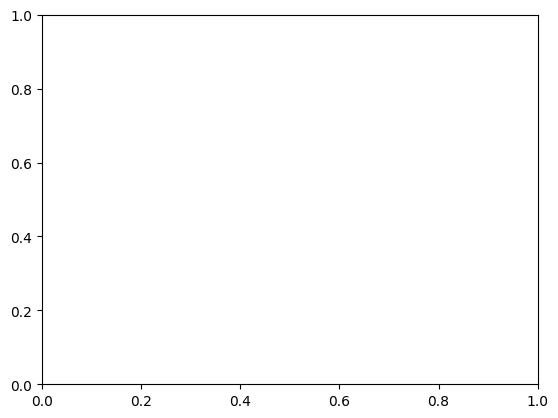

In [25]:
plt.imshow(img0_array[:,:,1:],cmap="uv")

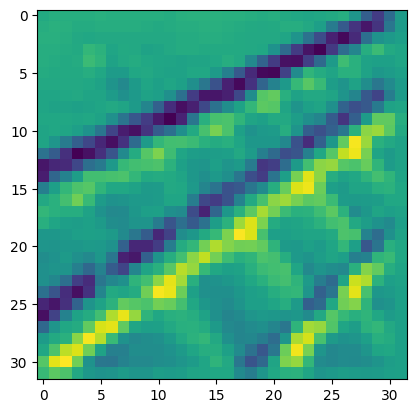

In [11]:
plt.imshow(img0_array[:,:,2])